# Titanic Survival - an Exhaustive Statistical Approach
## Machine Learning analysis supported by statistics best practices
### Based on "Python for Data Science and Machine Learning Bootcamp" course by Jose Portilla
Notebook written by Bruno Scheibler

** 1st: Import useful python modules **

In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

** 2nd: Import train.csv data **

In [116]:
df = pd.read_csv('train.csv')

** 3rd: Check data frame info **

In [117]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


**Importante note:** as signaled above, there are missing values in columns Age, Cabin and Embarked

In [119]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Visualize missing numerical values using seaborn:

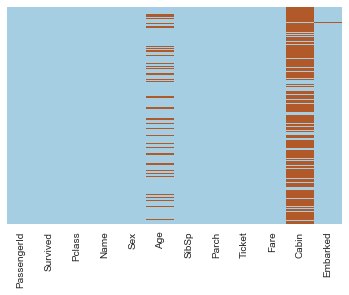

In [120]:
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap='Paired')

To fill in missing Age data, it is important to first identify which variables/categories are correlated to its values.

Take Passenger Class, for instance:

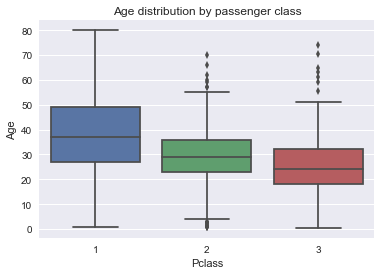

In [121]:
sns.boxplot(x='Pclass',y='Age',data=df).set_title('Age distribution by passenger class')

The mean age seems to differs between the passenger classes, but we must check if these differences are statistically significant. Therefore, we proceed to the **ANOVA (Analysis of Variance) test** using the **scipy** module.

According to the scipy notes:

> The ANOVA test has important assumptions that must be satisfied in order
> for the associated p-value to be valid.

> 1. The samples are independent.
> 2. Each sample is from a normally distributed population.
> 3. The population standard deviations of the groups are all equal.  This
>    property is known as homoscedasticity.

The first assumption is already satisfied, since each value of one group does not correspond directly to a value in the other group.
However, the last 2 assumptions have to be checked.

**Identifying normal distribution fit**

The mean and median values of normal distributions are the same, considering the curve is equally distributed on both sides. Therefore, the skewness and "excess" kurtosis are near zero. The stats.normaltest() function from scipy checks these two characteristics automatically.

But first, let's check each class group graphically:

In [122]:
AgeFirstClass = df[df['Pclass']==1]['Age'].dropna()
AgeSecondClass = df[df['Pclass']==2]['Age'].dropna()
AgeThirdClass = df[df['Pclass']==3]['Age'].dropna()

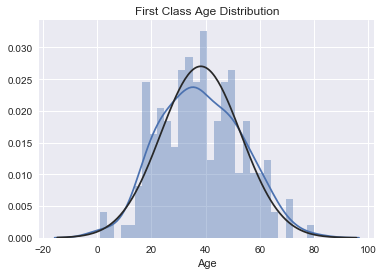

In [123]:
#import normal distribution to plot fit line
from scipy.stats import norm
#plot seaborn chart for 1st class age distribution
sns.distplot(AgeFirstClass, bins=30, fit=norm).set_title('First Class Age Distribution')

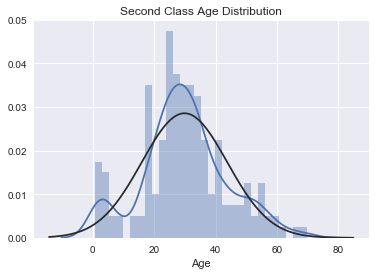

In [124]:
#plot seaborn chart for 2nd class age distribution
sns.distplot(AgeSecondClass, bins=30, fit=norm).set_title('Second Class Age Distribution')

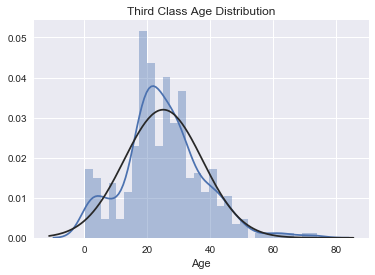

In [125]:
#plot seaborn chart for 3rd class age distribution
sns.distplot(AgeThirdClass, bins=30, fit=norm).set_title('Third Class Age Distribution')

Running the normal test, the results are the following:

In [126]:
from scipy import stats

In [127]:
# 1st class age normality test
stats.normaltest(AgeFirstClass)

NormaltestResult(statistic=1.6809586852884995, pvalue=0.43150363575423278)

Considering alpha = 0.05, we cannot reject the null hypothesis (that is, the sample comes from a normal distribution).

Let's do the same for the two other classes:

In [128]:
# 2nd class age normality test
stats.normaltest(AgeSecondClass)

NormaltestResult(statistic=1.1558018368785472, pvalue=0.56107487326230898)

In [129]:
# 3rd class age normality test
stats.normaltest(AgeThirdClass)

NormaltestResult(statistic=21.119072465384342, pvalue=2.5944880976350556e-05)

watch out for scientific notation:

In [130]:
print('%.6f'%stats.normaltest(AgeThirdClass).pvalue)

0.000026


It seems that the 3rd class' age doesn't follow a normal distribution...

### **Important:**

Some people say that the normal distribution assumption is actually referred to its residuals. In this case, the following tests may be done:

In [131]:
def plot_norm_residuals(sample,title):
    Frequency = sample.value_counts()/len(sample)
    Residuals = pd.DataFrame(data=Frequency.values,index=Frequency.index,columns=['Frequency'])
    Residuals['Prediction'] = stats.norm.pdf((Residuals.index-np.mean(sample))/np.std(sample))/np.std(sample)
    Residuals['Residuals']=Residuals['Prediction']-Residuals['Frequency']
    if stats.normaltest(Residuals['Residuals']).pvalue >=0.05:
        print('Residuals follow normal distribution')
    else:
        print('Residuals do NOT follow normal distribution')
    sns.distplot(np.sort(Residuals['Residuals']),bins=30,fit=norm).set_title(title+' Residuals Distribution')

Residuals follow normal distribution


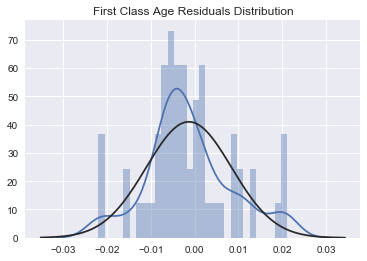

In [132]:
plot_norm_residuals(AgeFirstClass,'First Class Age')

Residuals follow normal distribution


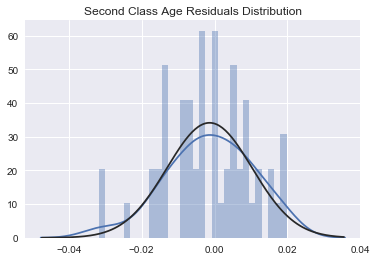

In [133]:
plot_norm_residuals(AgeSecondClass,'Second Class Age')

Residuals follow normal distribution


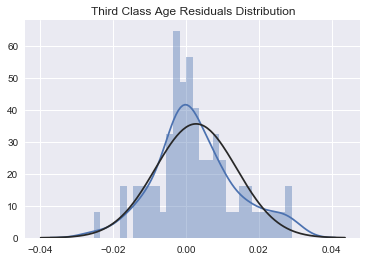

In [134]:
plot_norm_residuals(AgeThirdClass,'Third Class Age')

This means that all samples follow normal distributions.

Next, to compare variances between the samples, the F test may be used:

In [135]:
print('1st Class Age Variance: %0.2f' %(np.var(AgeFirstClass)))
print('2nd Class Age Variance: %0.2f' %(np.var(AgeSecondClass)))
print('3rd Class Age Variance: %0.2f' %(np.var(AgeThirdClass)))

1st Class Age Variance: 217.95
2nd Class Age Variance: 194.90
3rd Class Age Variance: 155.70


In [136]:
alpha=0.05
def compare_variances(sample1,sample2):
    p_value=stats.f.sf(np.var(sample1)/np.var(sample2),len(sample1)-1,len(sample2)-1)
    if p_value < alpha:
        return 'the variances are statistically different'
    else:
        return 'the variances are NOT statistically different'

In [137]:
print('1st X 2nd variance comparison:',compare_variances(AgeFirstClass,AgeSecondClass))
print('1st X 3rd variance comparison:',compare_variances(AgeFirstClass,AgeThirdClass))
print('2nd X 3rd variance comparison:',compare_variances(AgeSecondClass,AgeThirdClass))

1st X 2nd variance comparison: the variances are NOT statistically different
1st X 3rd variance comparison: the variances are statistically different
2nd X 3rd variance comparison: the variances are statistically different


What if we join the 2nd and 3rd class to create a unique class?

In [138]:
AgeSecThiClass = np.append(AgeSecondClass,AgeThirdClass)
np.var(AgeSecThiClass)

173.48299247553661

In [139]:
compare_variances(AgeFirstClass,AgeSecThiClass)

'the variances are statistically different'

Unfortunately **the last assumption for the ANOVA test wasn't met**.

An alternative test in this case is a two-by-two comparison of the means using 2-sample T tests, for independent samples with different (or not) variances.

In [140]:
def T_test(sample1,sample2,var):
    p_value = stats.ttest_ind(sample1,sample2,equal_var=var).pvalue
    if p_value >= 0.05:
        return 'the means are NOT statistically different'
    else:
        return 'the means are statistically different'

In [141]:
print('1st X 2nd mean comparison:',T_test(AgeFirstClass,AgeSecondClass,True))
print('1st X 3rd mean comparison:',T_test(AgeFirstClass,AgeThirdClass,False))
print('2nd X 3rd mean comparison:',T_test(AgeSecondClass,AgeThirdClass,False))

1st X 2nd mean comparison: the means are statistically different
1st X 3rd mean comparison: the means are statistically different
2nd X 3rd mean comparison: the means are statistically different


This means the PClass column may be used to fill in missing Age data

What about the SibSp (Siblings and Spouses) column?

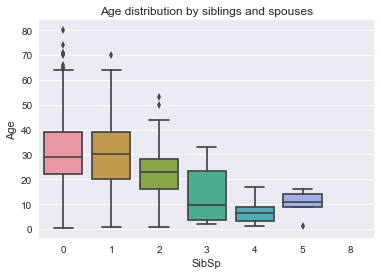

In [142]:
sns.boxplot(x='SibSp',y='Age',data=df).set_title('Age distribution by siblings and spouses')

As the siblings and spouses data are mixed into the same column, the difference becomes visible from 3. It means that values 0 and 1 represents mostly adults with none or one spouse. From 2 and beyond, the age refers to young people, considering the fact that one person do not have more than 1 spouse.

In this case, the ANOVA test is probably not suitable as well. To confirm this, just one sample is enough (take 3 siblings and spouses, for example).

In [143]:
AgeSibSp0 = df[df['SibSp']==0]['Age'].dropna()
AgeSibSp1 = df[df['SibSp']==1]['Age'].dropna()
AgeSibSp2 = df[df['SibSp']==2]['Age'].dropna()
AgeSibSp3 = df[df['SibSp']==3]['Age'].dropna()
AgeSibSp4 = df[df['SibSp']==4]['Age'].dropna()
AgeSibSp5 = df[df['SibSp']==5]['Age'].dropna()

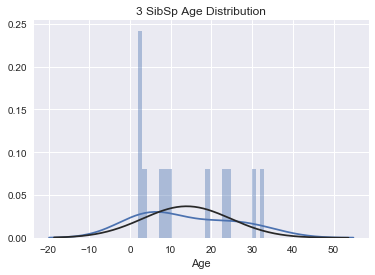

In [144]:
sns.distplot(AgeSibSp3, bins=30, fit=norm).set_title('3 SibSp Age Distribution')

/Users/Bruno/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


Residuals do NOT follow normal distribution


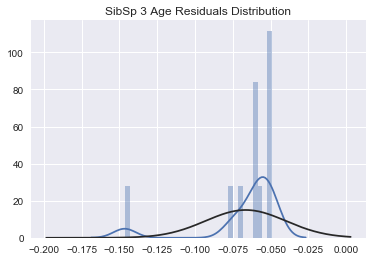

In [145]:
plot_norm_residuals(AgeSibSp3,'SibSp 3 Age')

In this case, a non-parametric alternative is the Kruskal-Wallis test, to compare median values among independent samples.

In [146]:
print('%.15f'%stats.kruskal(AgeSibSp0,AgeSibSp1,AgeSibSp2,AgeSibSp3,AgeSibSp4,AgeSibSp5).pvalue)

0.000000000000013


Since p_value << 0.05, we can reject the null hypothesis and afirm that the medians are not all the same.

What if the previous observation is taken into consideration and the column is split into two clusters? Would it increase its significance?

In [147]:
AgeSibSp01 = df[df['SibSp']<=1]['Age'].dropna()
AgeSibSp2345 = df[df['SibSp']>=2]['Age'].dropna()

In [148]:
print('%.15f' % stats.kruskal(AgeSibSp01,AgeSibSp2345).pvalue)

0.000000000000003


Now we have two categorical columns to help us fill in the missing Age data:

In [149]:
df['Adult_Child']=df['SibSp'].map(lambda x: 'Adult' if x<=2 else 'Child')

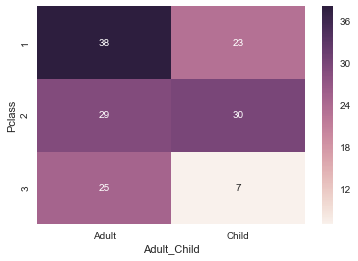

In [150]:
Corr = df[['Pclass','Adult_Child','Age']]
Corr = Corr.groupby(['Pclass','Adult_Child'],as_index=False).median()
Corr = Corr.pivot(index='Pclass',columns='Adult_Child',values='Age')
sns.heatmap(Corr,annot=True)

In [151]:
def fill_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    Adult_Child = cols[2]
    if pd.isnull(Age):
        return Corr[Adult_Child][Pclass]
    else:
        return Age

In [152]:
df['Age'] = df[['Age','Pclass','Adult_Child']].apply(fill_age,axis=1)

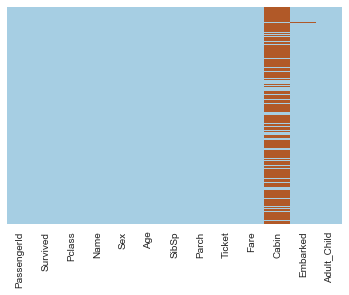

In [153]:
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap='Paired')

In [154]:
df.drop('Cabin',axis=1,inplace=True)
df.dropna(inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Adult_Child
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Adult


In [155]:
Names = pd.DataFrame(df['Name'].str.split(', ',1).tolist(),columns = ['Last Name','Name'])
Names.head()

,Last Name,Name
0,Braund,Mr. Owen Harris
1,Cumings,Mrs. John Bradley (Florence Briggs Thayer)
2,Heikkinen,Miss. Laina
3,Futrelle,Mrs. Jacques Heath (Lily May Peel)
4,Allen,Mr. William Henry


In [156]:
Title = pd.DataFrame(Names['Name'].str.split('.',1).tolist(),columns=['Title','Name'])
Title['Title'].value_counts()

Mr              517
Miss            181
Mrs             124
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Mme               1
Capt              1
Sir               1
Don               1
Jonkheer          1
Lady              1
Ms                1
the Countess      1
Name: Title, dtype: int64

In [157]:
df = pd.concat([df,Title['Title']],axis=1)

In [185]:
Title_Prop = df[['Survived','Title']]
Title_Prop['Count']=1
Title_Prop = Title_Prop.groupby(['Survived','Title'],as_index=False).sum()
Title_Prop = Title_Prop.pivot(index='Survived',columns='Title',values='Count')

/Users/Bruno/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [187]:
Title_Prop = Title_Prop.T

In [192]:
Title_Prop.fillna(0,inplace=True)

In [194]:
Title_Prop['Prop'] = Title_Prop[1]/(Title_Prop[0]+Title_Prop[1])

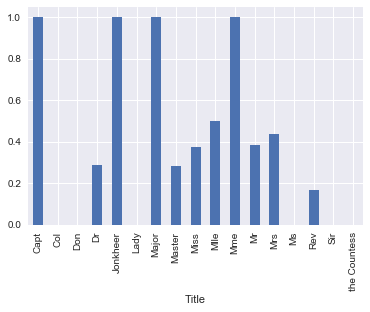

In [209]:
Title_Prop['Prop'].plot(kind='bar')

In [210]:
sex = pd.get_dummies(df['Sex'],drop_first=True)
embark = pd.get_dummies(df['Embarked'],drop_first=True)
adult = pd.get_dummies(df['Adult_Child'],drop_first=True)
title = pd.get_dummies(df['Title'],drop_first=True)
df.drop(['Sex','Embarked','Ticket','Adult_Child','Title'],axis=1,inplace=True)
df = pd.concat([df,sex,embark,adult,title],axis=1)
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Fare,male,Q,...,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",22.0,1.0,0.0,7.2500,1,0,...,0,0,0,0,1,0,0,0,0,0
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1.0,0.0,71.2833,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",26.0,0.0,0.0,7.9250,0,0,...,0,1,0,0,0,0,0,0,0,0
3,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1.0,0.0,53.1000,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5.0,0.0,3.0,"Allen, Mr. William Henry",35.0,0.0,0.0,8.0500,1,0,...,0,0,0,0,1,0,0,0,0,0


In [211]:
df.dropna(inplace=True)

In [213]:
X_train = df.drop(['PassengerId','Survived','Name','Dr','Rev','Col','Major','Mlle','Mme','Sir','Don','Jonkheer','Lady','Ms','the Countess'],axis=1)

In [214]:
y_train = df['Survived']

In [215]:
from sklearn.linear_model import LogisticRegression

In [216]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [266]:
X_test = pd.read_csv('test.csv')

In [267]:
X_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


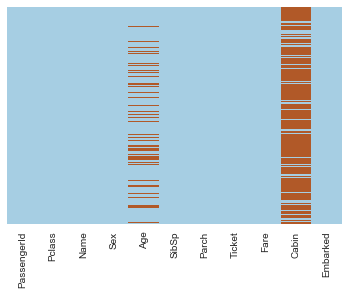

In [268]:
sns.heatmap(X_test.isnull(),cbar=False,yticklabels=False,cmap='Paired')

In [269]:
X_test.drop('Cabin',axis=1,inplace=True)

In [270]:
X_test['Adult_Child']=X_test['SibSp'].map(lambda x: 'Adult' if x<=2 else 'Child')

In [271]:
X_test['Age'] = X_test[['Age','Pclass','Adult_Child']].apply(fill_age,axis=1)

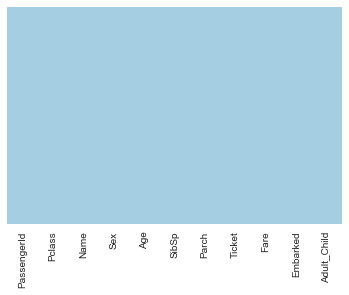

In [272]:
sns.heatmap(X_test.isnull(),cbar=False,yticklabels=False,cmap='Paired')

In [273]:
Names_test = pd.DataFrame(X_test['Name'].str.split(', ',1).tolist(),columns = ['Last Name','Name'])
Title_test = pd.DataFrame(Names_test['Name'].str.split('.',1).tolist(),columns=['Title','Name'])
X_test = pd.concat([X_test,Title_test['Title']],axis=1)

In [274]:
sex_test = pd.get_dummies(X_test['Sex'],drop_first=True)
embark_test = pd.get_dummies(X_test['Embarked'],drop_first=True)
adult_test = pd.get_dummies(X_test['Adult_Child'],drop_first=True)
title_test = pd.get_dummies(X_test['Title'],drop_first=True)
X_test.drop(['Sex','Embarked','Ticket','Adult_Child','Title','Name'],axis=1,inplace=True)
X_test = pd.concat([X_test,sex_test,embark_test,adult_test,title_test],axis=1)

In [275]:
X_test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Child,Dona,Dr,Master,Miss,Mr,Mrs,Ms,Rev
0,892,3,34.5,0,0,7.8292,1,1,0,0,0,0,0,0,1,0,0,0
1,893,3,47.0,1,0,7.0000,0,0,1,0,0,0,0,0,0,1,0,0
2,894,2,62.0,0,0,9.6875,1,1,0,0,0,0,0,0,1,0,0,0
3,895,3,27.0,0,0,8.6625,1,0,1,0,0,0,0,0,1,0,0,0
4,896,3,22.0,1,1,12.2875,0,0,1,0,0,0,0,0,0,1,0,0


In [276]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Fare           417 non-null float64
male           418 non-null uint8
Q              418 non-null uint8
S              418 non-null uint8
Child          418 non-null uint8
Dona           418 non-null uint8
Dr             418 non-null uint8
Master         418 non-null uint8
Miss           418 non-null uint8
Mr             418 non-null uint8
Mrs            418 non-null uint8
Ms             418 non-null uint8
Rev            418 non-null uint8
dtypes: float64(2), int64(4), uint8(12)
memory usage: 24.6 KB


In [278]:
X_test.drop(['Dona','Dr','Ms','Rev'],axis=1,inplace=True)

In [279]:
X_test.set_index('PassengerId',inplace=True)
X_test.head()

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Child,Master,Miss,Mr,Mrs
PassengerId,,,,,,,,,,,,,
892,3,34.5,0,0,7.8292,1,1,0,0,0,0,1,0
893,3,47.0,1,0,7.0000,0,0,1,0,0,0,0,1
894,2,62.0,0,0,9.6875,1,1,0,0,0,0,1,0
895,3,27.0,0,0,8.6625,1,0,1,0,0,0,1,0
896,3,22.0,1,1,12.2875,0,0,1,0,0,0,0,1


In [283]:
X_test.isnull().any()

Pclass    False
Age       False
SibSp     False
Parch     False
Fare       True
male      False
Q         False
S         False
Child     False
Master    False
Miss      False
Mr        False
Mrs       False
dtype: bool

In [284]:
X_test[X_test.isnull().T.any().T]

,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Child,Master,Miss,Mr,Mrs
PassengerId,,,,,,,,,,,,,
1044,3,60.5,0,0,NaN,1,0,1,0,0,0,1,0


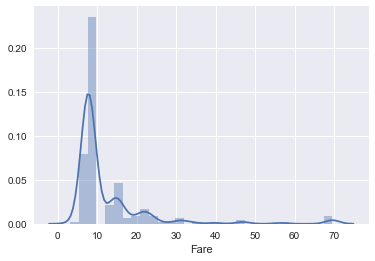

In [292]:
ThirdClassFare = X_test[X_test['Pclass']==3]['Fare']
sns.distplot(ThirdClassFare.dropna())

In [304]:
X_test['Fare'] = X_test['Fare'].map(lambda x: ThirdClassFare.median() if pd.isnull(x) else x)

In [305]:
predictions = logmodel.predict(X_test)

In [306]:
predictions

array([ 0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
        0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,
        0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
        1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0

In [307]:
X_test.index.values

array([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,  902,
        903,  904,  905,  906,  907,  908,  909,  910,  911,  912,  913,
        914,  915,  916,  917,  918,  919,  920,  921,  922,  923,  924,
        925,  926,  927,  928,  929,  930,  931,  932,  933,  934,  935,
        936,  937,  938,  939,  940,  941,  942,  943,  944,  945,  946,
        947,  948,  949,  950,  951,  952,  953,  954,  955,  956,  957,
        958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,
        969,  970,  971,  972,  973,  974,  975,  976,  977,  978,  979,
        980,  981,  982,  983,  984,  985,  986,  987,  988,  989,  990,
        991,  992,  993,  994,  995,  996,  997,  998,  999, 1000, 1001,
       1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
       1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,
       1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034,
       1035, 1036, 1037, 1038, 1039, 1040, 1041, 10

In [308]:
Answer=pd.DataFrame(data=X_test.index.values)
Answer['Survived'] = predictions
Answer.columns = ['PassengerId','Survived']
Answer.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0


In [309]:
Answer = Answer.astype(int)

In [310]:
Answer.to_csv('Titanic_Answer.csv',index=False)